In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? Y


In [2]:
#Import CDO and make sure it works
from cdo import *

#--Initialize CDO
cdo=Cdo()
%matplotlib inline

#print cdo.operators # query operators

import os
import matplotlib.pyplot as plt
from matplotlib import cm
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import Rbf
import random

os.chdir('/vftmp/Jane.Baldwin/STEP/CORRvVAR/')

In [3]:
#DATA FILES

days = {'def1':'3114','def2':'3336','def3':'6217'}

#Raw data for analysis
cntl_raw = '/ptmp/jwb/RAW/CONTROL/atmos_daily.04010101-04951231.t_ref_min.nc'
xco2_raw = '/ptmp/jwb/RAW/2XCO2/atmos_daily.04010101-04951231.t_ref_min.nc'
cntl_ann = '/ptmp/jwb/RAW/CONTROL/atmos.0401-0500.t_ref_min.nc'
xco2_ann = '/ptmp/jwb/RAW/2XCO2/atmos.0401-0500.t_ref_min.nc'

#Processed data for analysis
cntl_proc = {}
xco2_proc = {}
for key,value in days.iteritems():
    cntl_proc[key] = '/vftmp/Jane.Baldwin/STEP/SYN_FIX/tn90pct_heatwaves_FLOR_Control_90pct_400yr_rNone_'+value+'_yearly_summer.nc'
    xco2_proc[key] = '/vftmp/Jane.Baldwin/STEP/SYN_FIX/tn90pct_heatwaves_FLOR_2XCO2_90pct_400yr_rNone_'+value+'_yearly_summer.nc'

In [4]:
#CALCULATE SIGNAL, VAR, AUTOCORR

#Signal of climate change (2XCO2-CONTROL annual mean warming at each location)
#cdo.timmean(input='-sub %s %s' %(xco2_ann,cntl_ann), options='-f nc', returnCdf=True, output='signal.nc')

#Calculate Daily Climatology
#cdo.ydaymean(input='%s' %(cntl_raw), options='-f nc', returnCdf=True, output='cntlclim.nc')

#Calculate Daily Anomalies
#cdo.ydaysub(input='%s %s' %(cntl_raw,'cntlclim.nc'), options='-f nc', returnCdf=True, output='cntlanom.nc')

#Amplitude of temperature variation (standard deviation of the raw temp data)
#cdo.timstd(input='-seldate,0401-01-01,0495-12-31 %s' %('cntlanom.nc'), options='-f nc', returnCdf=True, output='anom_amplitude.nc')

#Autocorrelation of temperature variation (r1 autocorrelation)
#cdo.timcor(input='-seldate,0401-01-04,0495-12-28 %s -seldate,0401-01-04,0495-12-28 -shifttime,1day %s' %('cntlanom.nc','cntlanom.nc'), options='-f nc', returnCdf=True, output='autocorr.nc')
#cdo.timcor(input='-seldate,0401-01-04,0495-12-28 %s -seldate,0401-01-04,0495-12-28 -shifttime,2day %s' %('cntlanom.nc','cntlanom.nc'), options='-f nc', returnCdf=True, output='autocorr2.nc')
#cdo.timcor(input='-seldate,0401-01-04,0495-12-28 %s -seldate,0401-01-04,0495-12-28 -shifttime,3day %s' %('cntlanom.nc','cntlanom.nc'), options='-f nc', returnCdf=True, output='autocorr3.nc')


In [5]:
#DERIVATIVE VARIABLES
#os.chdir('/vftmp/Jane.Baldwin/STEP/')

#Change in compound proportion
cntl_proc_dat = {}
cntl_ahw2f = {}
cntl_ahwf = {}
cntl_cp = {}
xco2_proc_dat = {}
xco2_ahw2f = {}
xco2_ahwf = {}
xco2_cp = {}
dp = {}

for key, value in days.iteritems():
    cntl_proc_dat[key] = Dataset(cntl_proc[key], 'r')
    cntl_ahw2f[key] = np.squeeze(cntl_proc_dat[key]['AHW2F_tn90pct'][:])
    cntl_ahwf[key] = np.squeeze(cntl_proc_dat[key]['AHWF_tn90pct'][:])
    cntl_cp[key] = np.mean(cntl_ahw2f[key]/cntl_ahwf[key],axis=0)
    xco2_proc_dat[key] = Dataset(xco2_proc[key], 'r')
    xco2_ahw2f[key] = np.squeeze(xco2_proc_dat[key]['AHW2F_tn90pct'][:])
    xco2_ahwf[key] = np.squeeze(xco2_proc_dat[key]['AHWF_tn90pct'][:])
    xco2_cp[key] = np.mean(xco2_ahw2f[key]/xco2_ahwf[key],axis=0)
    dp[key] = xco2_cp[key] - cntl_cp[key]

#Standard deviation over mean warming signal
am = np.squeeze(Dataset('anom_amplitude.nc','r')['t_ref_min'][:])
si = np.squeeze(Dataset('signal.nc','r')['t_ref_min'][:])
amsi = am/si

#Lag 1-day autorcorrelation
cor = np.squeeze(Dataset('autocorr.nc','r')['t_ref_min'][:])

In [6]:
#Define radial basis function interpolation function
def corvar_rbf(nd,cor,amsi):
    os.chdir('/vftmp/Jane.Baldwin/')
    
    mask=~np.array(nd.mask) #might need to change to ndch for some compound (like 3336)
    nd=nd[mask]
    cor=cor[mask]
    amsi=amsi[mask]

    x = cor #np.random.rand(sz)*4.0-2.0
    y = amsi#np.random.rand(sz)*4.0-2.0
    z = nd #x*np.exp(-x**2-y**2)
    ngrid = 100
    tx = np.linspace(0,1,ngrid)
    ty=np.linspace(0,10,ngrid)
    XI, YI = np.meshgrid(tx, ty)
    sz=x.shape[0]

    # use RBF
    n=20
    rands=5000
    ZI = np.zeros((n,np.shape(XI)[0],np.shape(XI)[1]))
    for i in range(0,n):
        samp = np.array(random.sample(zip(x,y,z),rands))
        rbfi= Rbf(samp[:,0],samp[:,1],samp[:,2],function='linear')
        ZI[i,...] = rbfi(XI,YI)
    
    dist=np.zeros((ngrid,ngrid))
    
    for i in range(ngrid):
        for j in range(ngrid):
            dist[i,j]=np.min((np.square(x-XI[i,j])+np.square((y-YI[i,j])/10))/2)
    maskd=(dist>0.00001)
    ZIm=np.mean(ZI,axis=0)
    ZImma = np.ma.masked_where(dist>0.0001,ZIm)
    return XI,YI,ZImma

In [7]:
#Perform the Radial Basis Function Interpolation
XI1 = {}
YI1 = {}
ZImma1 = {}
for key, value in days.iteritems():
    XI1[key],YI1[key],ZImma1[key] = corvar_rbf(dp[key],cor,amsi)

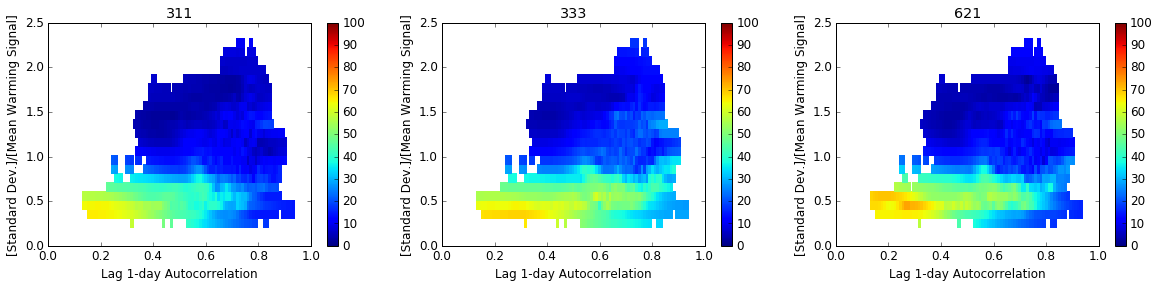

In [9]:
#Figure
fig = plt.figure(figsize=(20,4))
plt.rcParams.update({'font.size': 12})

fig = plt.subplot(1,3,1)
plt.pcolor(XI1['def1'],YI1['def1'],ZImma1['def1']*100,cmap=cm.jet,vmin=0,vmax=100)
plt.colorbar()
#plt.figtext(.2, .8, 'mean=%.2f'%np.mean(dp*100),fontsize=18)
plt.xlabel('Lag 1-day Autocorrelation')
plt.ylabel('[Standard Dev.]/[Mean Warming Signal]')
#plt.title('Tn 90th '+day)
plt.ylim([0,2.5])
#plt.savefig('corrvvar'+day+'.pdf',bbox_inches='tight')
plt.title(days['def1'][0:3])

fig = plt.subplot(1,3,2)
plt.pcolor(XI1['def2'],YI1['def2'],ZImma1['def2']*100,cmap=cm.jet,vmin=0,vmax=100)
plt.colorbar()
#plt.figtext(.2, .8, 'mean=%.2f'%np.mean(dp*100),fontsize=18)
plt.xlabel('Lag 1-day Autocorrelation')
plt.ylabel('[Standard Dev.]/[Mean Warming Signal]')
#plt.title('Tn 90th '+day)
plt.ylim([0,2.5])
#plt.savefig('corrvvar'+day+'.pdf',bbox_inches='tight')
plt.title(days['def2'][0:3])

fig = plt.subplot(1,3,3)
plt.pcolor(XI1['def3'],YI1['def3'],ZImma1['def3']*100,cmap=cm.jet,vmin=0,vmax=100)
plt.colorbar()
#plt.figtext(.2, .8, 'mean=%.2f'%np.mean(dp*100),fontsize=18)
plt.xlabel('Lag 1-day Autocorrelation')
plt.ylabel('[Standard Dev.]/[Mean Warming Signal]')
#plt.title('Tn 90th '+day)
plt.ylim([0,2.5])
plt.title(days['def3'][0:3])

plt.savefig('corrvvar3def.pdf',bbox_inches='tight')

plt.show()